In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from imblearn.over_sampling import RandomOverSampler,  SVMSMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
augmented_test=pd.read_csv("augmented_test.csv")
test2=augmented_test[['feature_1', 'feature_2','feature_3','feature_4']]

"\nOnly feature 1 and 4 seems to have a significative correlation with the survival probability. \nIt doesn't mean that the other features are not usefull. \nSubpopulations in these features can be correlated with the labels. To determine this, we need to explore  these features in detail.\n"

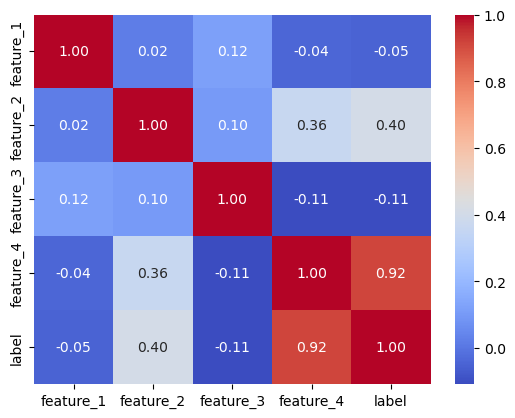

In [3]:
#From the Correlation matrix between numerical values and labels     
g = sns.heatmap(train[['feature_1', 'feature_2', 'feature_3','feature_4','label']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

'''
Only feature 1 and 4 seems to have a significative correlation with the survival probability. 
It doesn't mean that the other features are not usefull. 
Subpopulations in these features can be correlated with the labels. To determine this, we need to explore  these features in detail.
'''

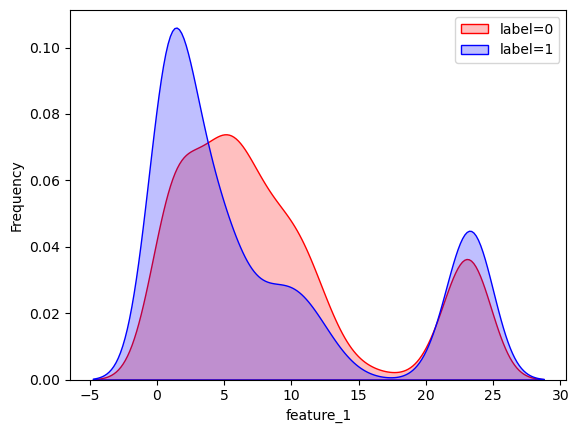

In [4]:
g = sns.kdeplot(train["feature_1"][(train["label"] == 0) & (train["feature_1"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["feature_1"][(train["label"] == 1) & (train["feature_1"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_1")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

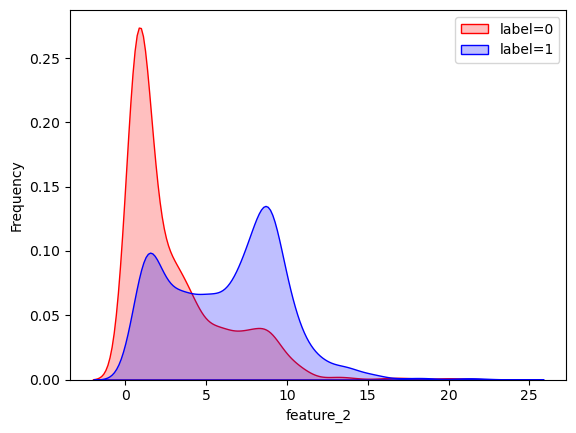

In [5]:
# Explore feature_2 vs label
g = sns.kdeplot(train["feature_2"][(train["label"] == 0) & (train["feature_2"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["feature_2"][(train["label"] == 1) & (train["feature_2"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_2")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

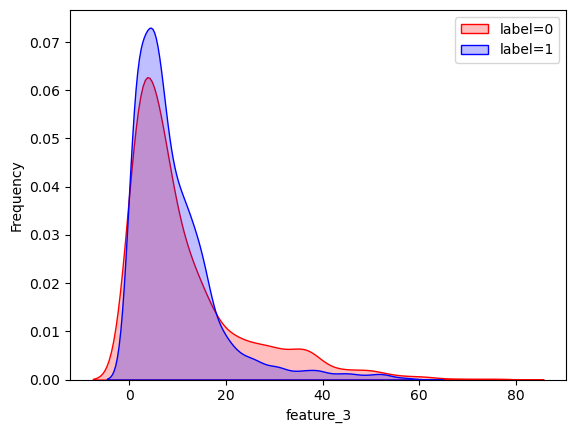

In [6]:
# Explore feature_3 vs label
g = sns.kdeplot(train["feature_3"][(train["label"] == 0) & (train["feature_3"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["feature_3"][(train["label"] == 1) & (train["feature_3"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_3")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

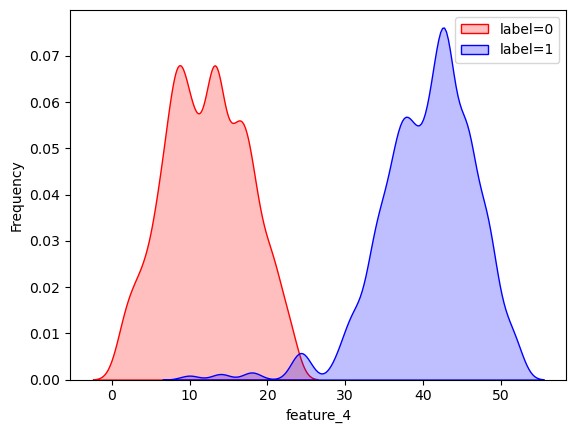

In [7]:
g = sns.kdeplot(train["feature_4"][(train["label"] == 0) & (train["feature_4"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["feature_4"][(train["label"] == 1) & (train["feature_4"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_4")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

In [8]:
#delete outliers in feature_4
train_del_outlier_4 = train.drop(train[(train['label'] == 1) & (train['feature_4'] <= 25)].index)

# feature_weights = [0.86207*(-0.05), 0.86207*0.4, -0.11*0.86207, 0.92*0.86207]
# train_del_outlier_4

In [9]:
total_train_feature=train[['feature_1', 'feature_2','feature_3', 'feature_4']]
total_train_label = train['label']

# total_train_feature = train_del_outlier_4[['feature_1', 'feature_2','feature_3', 'feature_4']]
# total_train_label = train_del_outlier_4['label']

final_test = test[['feature_1', 'feature_2','feature_3','feature_4']]


print(sorted(Counter(total_train_label).items()))
#need resample

[(0, 2000), (1, 4000)]


In [10]:
sm = SVMSMOTE(random_state=0)
over_feature, over_label = sm.fit_resample(total_train_feature, total_train_label)
print(sorted(Counter(over_label).items()))

[(0, 4000), (1, 4000)]


In [11]:
scaler = preprocessing.StandardScaler().fit(over_feature)
train_transformed = scaler.transform(over_feature)
test_transformed = scaler.transform(final_test)
test2_transformed=scaler.transform(test2)

X_train, X_test, y_train, y_test = train_test_split(train_transformed, over_label, test_size=0.25, random_state=0)

In [12]:
clf_bala_bagging = BalancedBaggingClassifier(estimator=SVC(C=0.01,kernel='rbf',gamma=0.1), n_estimators=10,random_state=0)
clf_bala_bagging.fit(X_train,y_train)
bagging_pred = clf_bala_bagging.predict(X_test)
print(accuracy_score(y_test, bagging_pred))

0.985


In [13]:
clf_bala_bagging.fit(train_transformed,over_label)
bagging_pred_final = clf_bala_bagging.predict(test_transformed)

to_submit = []
for eid, pred in zip(test['example_id'].values, bagging_pred_final):
    to_submit.append({"example_id": eid, "prediction": pred})
to_submit = pd.DataFrame(to_submit)



In [14]:
test_ana=test[['feature_1', 'feature_2','feature_3', 'feature_4']]
test_ana['label']=bagging_pred_final
test_ana

,feature_1,feature_2,feature_3,feature_4,label
0,2.919722,4.300000,0.834,19.0,0
1,23.430556,9.173056,6.033,23.0,0
2,0.781944,6.190000,29.728,34.0,1
3,7.342778,0.353611,0.573,25.0,0
4,0.989444,8.069722,11.259,34.0,1
...,...,...,...,...,...
795,3.643333,2.845833,5.795,34.0,1
796,0.500000,10.516111,6.244,36.0,1
797,7.449167,1.388056,4.734,39.0,1
798,10.128889,1.144167,35.184,20.0,0


In [29]:
test_ana[(test_ana["feature_4"]<=25) & (test_ana["label"]==0) ]

,feature_1,feature_2,feature_3,feature_4,label
0,2.919722,4.300000,0.834,19.0,0
1,23.430556,9.173056,6.033,23.0,0
3,7.342778,0.353611,0.573,25.0,0
5,23.847778,8.334722,16.794,22.0,0
7,8.370833,1.437222,8.894,20.0,0
...,...,...,...,...,...
787,23.054444,3.029722,10.571,20.0,0
790,3.836111,5.290556,16.221,20.0,0
792,14.959167,0.744167,3.680,22.0,0
794,10.215833,1.955278,6.387,18.0,0


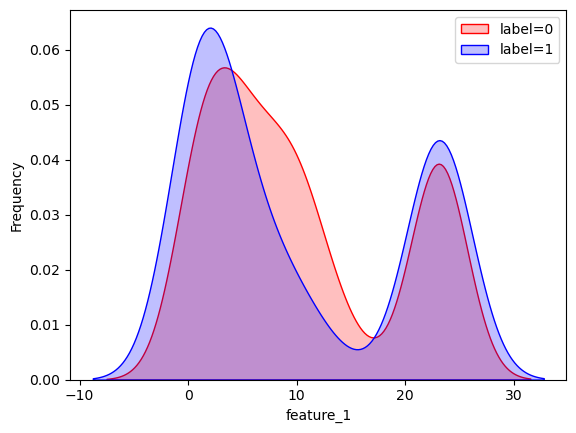

In [15]:
g = sns.kdeplot(test_ana["feature_1"][(test_ana["label"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(test_ana["feature_1"][(test_ana["label"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_1")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

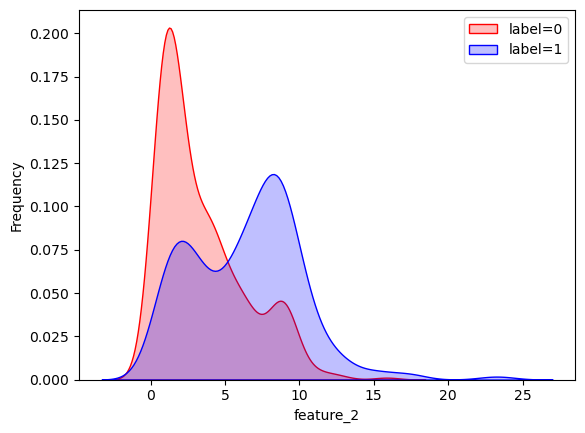

In [16]:
g = sns.kdeplot(test_ana["feature_2"][(test_ana["label"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(test_ana["feature_2"][(test_ana["label"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_2")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

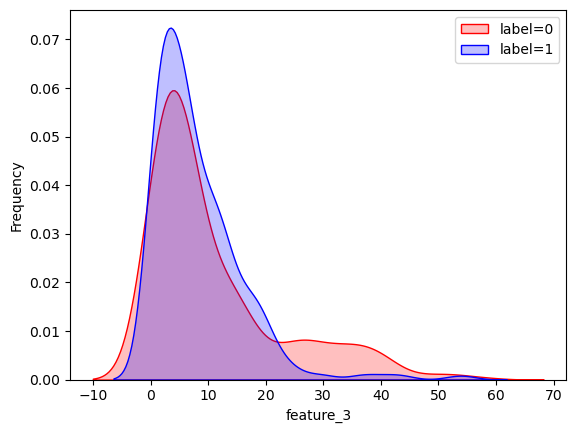

In [17]:
g = sns.kdeplot(test_ana["feature_3"][(test_ana["label"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(test_ana["feature_3"][(test_ana["label"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_3")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

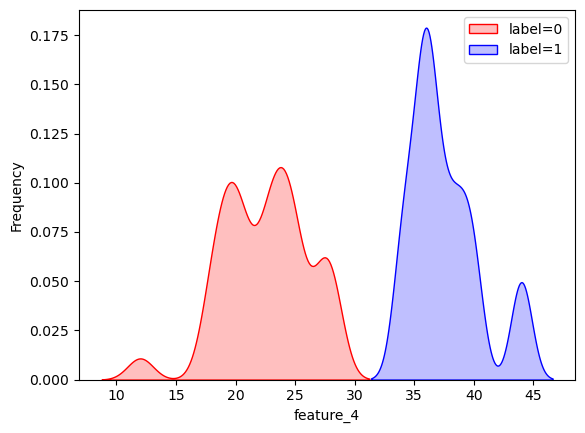

In [18]:
g = sns.kdeplot(test_ana["feature_4"][(test_ana["label"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(test_ana["feature_4"][(test_ana["label"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("feature_4")
g.set_ylabel("Frequency")
g = g.legend(["label=0","label=1"])

In [21]:
# Prediction of augmented test
clf_bala_bagging.fit(train_transformed,over_label)
bagging_pred_augment = clf_bala_bagging.predict(test2_transformed)
print(sorted(Counter(bagging_pred_augment).items()))

[(0, 499), (1, 4816)]


In [24]:
to_submit3 = []
for eid, pred in zip(augmented_test['example_id'].values, bagging_pred_augment):
    to_submit3.append({"example_id": eid, "prediction": pred})
to_submit3 = pd.DataFrame(to_submit3)
# to_submit3.to_csv("120090046 augmented.csv", index=False)

In [20]:
#back up model


# svm_predictor = SVC(C=0.0005,gamma=0.1,kernel='rbf')
# svm_predictor = svm_predictor.fit(train_transformed, over_label)
# svm_result = svm_predictor.predict(test_transformed)

# to_submit2 = []
# for eid, pred in zip(test['example_id'].values, svm_result):
#     to_submit2.append({"example_id": eid, "prediction": pred})
# to_submit2 = pd.DataFrame(to_submit)

# merged2 = pd.merge(to_submit2, c100, on="example_id", how="outer", suffixes=("_df1","_df2"))
# diff2 = merged2[merged2['prediction_df1'] != merged2['prediction_df2']]
# print(len(diff2))

# to_submit2.to_csv("sub2.csv", index=False)